In [2]:
%load_ext autoreload
%autoreload 2
# load GPR from the parent directory

import os,sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)
from TwoLocusGPR import GPR,MSD_functions,utils,Fit_MSD
from matplotlib import pyplot as plt
import numpy as np
import jax.numpy as jnp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First we sample a few tracks to fit

In [4]:
ntracks = 50
noise = .5
Gamma = 0.5
J = 1
alpha = 0.3
n = 2.0
ndims = 3

tmin,tmax = 0,6*60 # minutes
dt = 0.5 # minutes 
ntimes = int((tmax - tmin) / dt) + 1
times = np.linspace(tmin,tmax,ntimes)

regressor = GPR(times,MSD_functions.Saturating_MSD,ndims)

theta = np.array([Gamma,J,alpha]*ndims + [noise]*ndims)
true_dat,noisy_dat = regressor.sample_prior(theta, ntracks,nanfrac=0.1)


Then we run the MSD fitting procedure with track bootstrap (as we have more than ~20 tracks. Otherwise we would've used block bootstrapping)

In [5]:
true_vals = np.array([Gamma,J,alpha] + [noise]*ndims)
res = Fit_MSD.fit_msd(
    noisy_dat,
    true_vals*np.random.uniform(0.5,2,size=true_vals.shape),
    dt,MSD_functions.Saturating_MSD,230,bootstrap_method="track")



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Then we plot the confidence intervals and the likelihood profiles

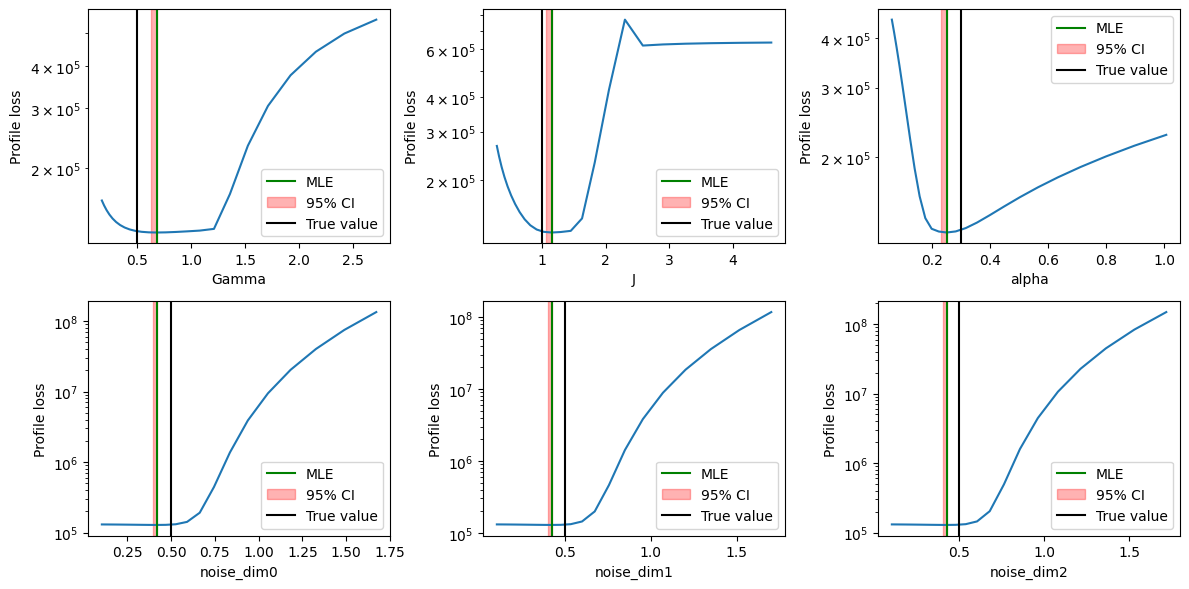

In [6]:
parameter_names = ["Gamma","J","alpha"] + [f"noise_dim{i}" for i in range(ndims)]

fig,ax = plt.subplots(2,3,figsize=(12,6))
for i in range(6):
    best_value = np.min(res[0][f"profile_param_{i}"]["profile_loss"])
    ax.flatten()[i].plot(res[0][f"profile_param_{i}"]["grid_natural"],res[0][f"profile_param_{i}"]["profile_loss"]+best_value+1)
    CIs = res[0]["CIs"][i]
    ax.flatten()[i].axvline(res[0]["final_params"][i], color='g',label="MLE")
    ax.flatten()[i].axvspan(CIs[0],CIs[1],color='r',alpha=0.3,label="95% CI")
    ax.flatten()[i].axvline(true_vals[i], color='k',label="True value")
    ax.flatten()[i].set(yscale="log", xlabel=parameter_names[i],ylabel="Profile loss")
    ax.flatten()[i].legend()

fig.tight_layout()

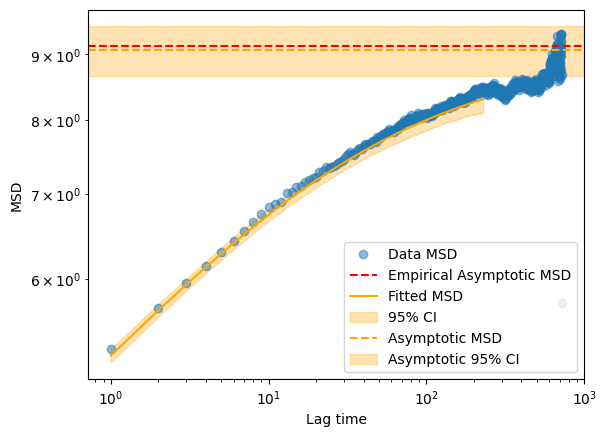

In [7]:


lags = np.arange(1,230)
data_lags = np.arange(1,noisy_dat.shape[1])
msd = utils.msd(noisy_dat, data_lags)
fig,ax = plt.subplots()
ax.loglog(data_lags,msd.sum(-1),"o",alpha=0.5, label='Data MSD')
ax.axhline(jnp.nanmean(noisy_dat**2,axis=(0,1)).sum()*2, color='r', ls='--', label='Empirical Asymptotic MSD')
ax.loglog(lags,res[0]["predicted msd"].sum(axis=-1)[:-1], color='orange', label='Fitted MSD')
cmat = res[0]["covar_matrix"]
ax.fill_between(lags,
                 res[0]["predicted msd"].sum(axis=-1)[:-1] - 2*jnp.sqrt(jnp.diagonal(cmat,axis1=0,axis2=1).sum(axis=0))[:-1],
                 res[0]["predicted msd"].sum(axis=-1)[:-1] + 2*jnp.sqrt(jnp.diagonal(cmat,axis1=0,axis2=1).sum(axis=0))[:-1],
                 color='orange', alpha=0.3, label='95% CI')
ax.axhline(res[0]["predicted msd"].sum(axis=-1)[-1],label='Asymptotic MSD', color='orange', ls='--')
ax.axhspan(res[0]["predicted msd"].sum(axis=-1)[-1] - 2*jnp.sqrt(cmat[-1,-1]).sum(),
            res[0]["predicted msd"].sum(axis=-1)[-1] + 2*jnp.sqrt(cmat[-1,-1]).sum(),
            color='orange', alpha=0.3, label='Asymptotic 95% CI')

ax.set(xlabel="Lag time", ylabel="MSD")
ax.legend()